# Determinants of Urban House Prices : Evidence from Berlin

as part of the course **Financial Data Analytics in Python**  
**Prof. Dr. Fabian Woebbeking**


Submitted by : **Morteza Motegh (222235729)**  
MLU - Martin Luther University Halle-Wittenberg

morteza.motegh@student.uni-halle.de

 ## Course Work: Berlin

In [2]:
pip install geopy


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import plotly.graph_objects as go
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

def get_wg_listings(url):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')
    return soup

def parse_listing(listing):
    title = listing.find('h3', class_='truncate_title noprint')
    location = listing.find('div', class_='col-xs-11')
    price = listing.find('div', class_='col-xs-3')
    availability = listing.find('div', class_='col-xs-5 text-center')
    size = listing.find('div', class_='col-xs-3 text-right')

    # Using BeautifulSoup to locate owner and online duration
    owner = listing.find('span', class_='ml5')
    online_duration = listing.find('span', style='color: #218700;')

    # Extracting location information
    location_text = location.text.strip() if location else None
    wg_type, district, street = None, None, None

    if location_text:
        location_parts = [part.strip() for part in location_text.split("|")]
        if len(location_parts) == 3:
            wg_type, city_district, street = location_parts
        elif len(location_parts) == 2:
            wg_type, city_district = location_parts
        elif len(location_parts) == 1:
            wg_type = location_parts[0]

        if city_district and "Berlin" in city_district:
            district = city_district.replace("Berlin", "").strip()

    # Remove extra spaces between dates in availability
    availability_text = availability.text.strip().replace(' ', '') if availability else None

    # Extract numeric value from online duration
    online_duration_text = online_duration.text.strip() if online_duration else None
    online_duration_numeric = int(''.join(filter(str.isdigit, online_duration_text))) if online_duration_text else None

    data = {
        'Title': title.text.strip() if title else None,
        'WG Type': wg_type,
        'City/District': district,
        'Street': street,
        'Price': f"{price.text.strip().replace('€', '').replace(' ', '')}" if price else None,
        'Availability': availability_text,
        'Size': f"{size.text.strip().replace('m²', '').replace(' ', '')}" if size else None,
        'Owner': owner.text.strip() if owner else None,
        'Online Duration': online_duration_numeric
    }

    return data

def get_postal_code(geolocator, city, street):
    try:
        location = geolocator.geocode(f"{street}, {city}, Berlin, Germany", timeout=10)
        if location:
            return location.address.split(',')[-2].strip()
    except GeocoderTimedOut:
        return get_postal_code(geolocator, city, street)
    return None

def scrape_wg_data(base_url, num_listings):
    listings_data = []
    page = 0
    geolocator = Nominatim(user_agent="wg_scraper")

    while len(listings_data) < num_listings:
        url = f"{base_url}?page={page}"
        soup = get_wg_listings(url)
        listings = soup.find_all('div', class_='offer_list_item')
        
        if not listings:
            break

        for listing in listings:
            data = parse_listing(listing)
            if data['City/District'] and data['Street']:
                postal_code = get_postal_code(geolocator, data['City/District'], data['Street'])
                data['Postal Code'] = postal_code
            listings_data.append(data)
            if len(listings_data) >= num_listings:
                break

        page += 1
        time.sleep(1)  # To avoid overwhelming the server with requests

    df = pd.DataFrame(listings_data)
    return df

# Scrape data
BASE_URL = 'https://www.wg-gesucht.de/wg-zimmer-in-Berlin.8.0.1.0.html'
NUM_LISTINGS = 200
wg_data_df = scrape_wg_data(BASE_URL, NUM_LISTINGS)

# Remove rows with null postal codes
wg_data_df.dropna(subset=['Postal Code'], inplace=True)

# Modify data 
wg_data_df['WG Type'] = wg_data_df['WG Type'].str.extract(r'(\d)').astype(float)
wg_data_df['Price'] = pd.to_numeric(wg_data_df['Price'], errors='coerce')
wg_data_df['Size'] = pd.to_numeric(wg_data_df['Size'], errors='coerce')
wg_data_df['Online Duration'] = pd.to_numeric(wg_data_df['Online Duration'], errors='coerce')

# Drop rows with missing values in relevant columns
wg_data_df.dropna(subset=['Price', 'Size', 'WG Type', 'Online Duration'], inplace=True)

# Create a plot 
wg_data_df

# Save the DataFrame to an Excel file
# wg_data_df.to_excel('wg_listings_berlin_postalcode.xlsx', index=False)

,Title,WG Type,City/District,Street,Price,Availability,Size,Owner,Online Duration,Postal Code
0,20qm WG-Zimmer in Wedding from August/September,2.0,Wedding,Afrikanische Str. 2,650,01.09.2024,20.0,Nico,2.0,13351
1,"Cosy shared room near Lake Tegel, in the count...",3.0,Tegel,bollestraße,630,01.11.2024,15.0,Gab S.,5.0,13509
2,Zwischenmiete: 15m2 Zimmer inkl. Balkon in ruh...,2.0,Neukölln,Roseggerstrasse 25,600,01.08.2024\n\n-31.12.2024,15.0,Asli,5.0,12059
3,Wunderschönes WG Zimmer mit Balkon nähe Kurfür...,5.0,Wilmersdorf,Nestorstr 18A,1050,31.07.2024,10.0,Constantin Huber,5.0,10709
6,WG in Gesundbrunnen sucht dich! 😃,3.0,Gesundbrunnen,Wollankstr 95,438,01.08.2024,15.0,Dave,8.0,13359
...,...,...,...,...,...,...,...,...,...,...
192,Wunderschönes WG Zimmer mit Balkon nähe Kurfür...,5.0,Wilmersdorf,Nestorstr 18A,1050,31.07.2024,10.0,Constantin Huber,7.0,10709
194,WG in Gesundbrunnen sucht dich! 😃,3.0,Gesundbrunnen,Wollankstr 95,438,01.08.2024,15.0,Dave,10.0,13359
196,Room lgbtq+ PoC friendly in Charlottenburg (fu...,2.0,Charlottenburg,Leibnizstr 1,700,01.08.2024\n\n-01.04.2025,15.0,Rene,12.0,10625
197,Room available for mid- to long-term rent,3.0,Tegel,Veitstr,700,01.10.2024,22.0,Ays,15.0,13507


In [4]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import plotly.graph_objects as go
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

def get_wg_listings(url):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')
    return soup

def parse_listing(listing):
    title = listing.find('h3', class_='truncate_title noprint')
    location = listing.find('div', class_='col-xs-11')
    price = listing.find('div', class_='col-xs-3')
    availability = listing.find('div', class_='col-xs-5 text-center')
    size = listing.find('div', class_='col-xs-3 text-right')

    # Using BeautifulSoup to locate owner and online duration
    owner = listing.find('span', class_='ml5')
    online_duration = listing.find('span', style='color: #218700;')

    # Extracting location information
    location_text = location.text.strip() if location else None
    wg_type, district, street = None, None, None

    if location_text:
        location_parts = [part.strip() for part in location_text.split("|")]
        if len(location_parts) == 3:
            wg_type, city_district, street = location_parts
        elif len(location_parts) == 2:
            wg_type, city_district = location_parts
        elif len(location_parts) == 1:
            wg_type = location_parts[0]

        if city_district and "Berlin" in city_district:
            district = city_district.replace("Berlin", "").strip()

    # Remove extra spaces between dates in availability
    availability_text = availability.text.strip().replace(' ', '') if availability else None

    # Extract numeric value from online duration
    online_duration_text = online_duration.text.strip() if online_duration else None
    online_duration_numeric = int(''.join(filter(str.isdigit, online_duration_text))) if online_duration_text else None

    data = {
        'Title': title.text.strip() if title else None,
        'WG Type': wg_type,
        'City/District': district,
        'Street': street,
        'Price': f"{price.text.strip().replace('€', '').replace(' ', '')}" if price else None,
        'Availability': availability_text,
        'Size': f"{size.text.strip().replace('m²', '').replace(' ', '')}" if size else None,
        'Owner': owner.text.strip() if owner else None,
        'Online Duration': online_duration_numeric
    }

    return data

def get_postal_code(geolocator, city, street):
    try:
        location = geolocator.geocode(f"{street}, {city}, Berlin, Germany", timeout=10)
        if location:
            return location.address.split(',')[-2].strip()
    except GeocoderTimedOut:
        return get_postal_code(geolocator, city, street)
    except Exception as e:
        print(f"Geocoding error: {e}")
    return None

def categorize_postal_code(postal_code):
    if postal_code is None:
        return 'Unknown'
    
    postal_code = int(postal_code)
    ranges = {
        'Mitte': [(10115, 10179), (10551, 10559), (13347, 13359), (13465, 13465), (13467, 13467), (13469, 13469)],
        'Friedrichshain-Kreuzberg': [(10243, 10249), (10961, 10999)],
        'Pankow': [(10405, 10439), (13187, 13189), (13156, 13156), (13158, 13158), (13159, 13159), (13127, 13127), (13129, 13129)],
        'Charlottenburg-Wilmersdorf': [(10585, 10585), (10587, 10587), (10589, 10589), (10623, 10629), (10707, 10719), (10711, 10711), (10777, 10779), (10713, 10713), (10715, 10715)],
        'Spandau': [(13581, 13599), (14052, 14052), (14089, 14089)],
        'Steglitz-Zehlendorf': [(12157, 12169), (12203, 12209), (12247, 12247), (12249, 12249), (12277, 12277), (12279, 12279), (14109, 14109), (14129, 14129), (14163, 14163), (14165, 14165), (14167, 14167), (14169, 14169)],
        'Tempelhof-Schöneberg': [(10777, 10779), (10827, 10829), (12101, 12101), (12103, 12103), (12105, 12105), (12107, 12107), (12109, 12109), (12277, 12277), (12279, 12279)],
        'Neukölln': [(12043, 12059), (12347, 12357), (12359, 12359)],
        'Treptow-Köpenick': [(12435, 12435), (12437, 12437), (12439, 12439), (12487, 12487), (12489, 12489), (12524, 12524), (12526, 12526), (12527, 12527), (12555, 12555), (12557, 12557), (12559, 12559), (12587, 12587), (12589, 12589)],
        'Marzahn-Hellersdorf': [(12619, 12619), (12621, 12621), (12623, 12623), (12627, 12627), (12629, 12629), (12679, 12679), (12681, 12681), (12683, 12683), (12685, 12685), (12687, 12687), (12689, 12689)],
        'Lichtenberg': [(10315, 10319), (10365, 10365), (10367, 10367), (10369, 10369), (13051, 13051), (13053, 13053), (13055, 13055), (13057, 13057), (13059, 13059)],
        'Reinickendorf': [(13403, 13403), (13405, 13405), (13407, 13407), (13409, 13409), (13435, 13435), (13437, 13437), (13439, 13439), (13465, 13465), (13467, 13467), (13469, 13469), (13503, 13503), (13505, 13505), (13507, 13507), (13509, 13509)]
    }

    for section, ranges_list in ranges.items():
        for start, end in ranges_list:
            if start <= postal_code <= end:
                return section
    return 'Unknown'

def scrape_wg_data(base_url, num_listings):
    listings_data = []
    page = 0
    geolocator = Nominatim(user_agent="wg_scraper")

    while len(listings_data) < num_listings:
        url = f"{base_url}?page={page}"
        soup = get_wg_listings(url)
        listings = soup.find_all('div', class_='offer_list_item')
        
        if not listings:
            break

        for listing in listings:
            data = parse_listing(listing)
            if data['City/District'] and data['Street']:
                postal_code = get_postal_code(geolocator, data['City/District'], data['Street'])
                data['Postal Code'] = postal_code
                data['Section'] = categorize_postal_code(postal_code) if postal_code else 'Unknown'
            else:
                data['Postal Code'] = None
                data['Section'] = 'Unknown'
            listings_data.append(data)
            if len(listings_data) >= num_listings:
                break

        page += 1
        time.sleep(1)  # To avoid overwhelming the server with requests

    df = pd.DataFrame(listings_data)
    return df

# Scrape data
BASE_URL = 'https://www.wg-gesucht.de/wg-zimmer-in-Berlin.8.0.1.0.html'
NUM_LISTINGS = 200
wg_data_df = scrape_wg_data(BASE_URL, NUM_LISTINGS)

# Remove rows with null postal codes
wg_data_df.dropna(subset=['Postal Code'], inplace=True)

# Modify data 
wg_data_df['WG Type'] = wg_data_df['WG Type'].str.extract(r'(\d)').astype(float)
wg_data_df['Price'] = pd.to_numeric(wg_data_df['Price'], errors='coerce')
wg_data_df['Size'] = pd.to_numeric(wg_data_df['Size'], errors='coerce')
wg_data_df['Online Duration'] = pd.to_numeric(wg_data_df['Online Duration'], errors='coerce')

# Drop rows with missing values in relevant columns
wg_data_df.dropna(subset=['Price', 'Size', 'WG Type', 'Online Duration'], inplace=True)

# Create a plot
wg_data_df

# Save the DataFrame to an Excel file
# wg_data_df.to_excel('wg_listings_berlin_sections.xlsx', index=False)


,Title,WG Type,City/District,Street,Price,Availability,Size,Owner,Online Duration,Postal Code,Section
0,20qm WG-Zimmer in Wedding from August/September,2.0,Wedding,Afrikanische Str. 2,650,01.09.2024,20.0,Nico,4.0,13351,Mitte
1,"Cosy shared room near Lake Tegel, in the count...",3.0,Tegel,bollestraße,630,01.11.2024,15.0,Gab S.,7.0,13509,Reinickendorf
2,Zwischenmiete: 15m2 Zimmer inkl. Balkon in ruh...,2.0,Neukölln,Roseggerstrasse 25,600,01.08.2024\n\n-31.12.2024,15.0,Asli,8.0,12059,Neukölln
3,Wunderschönes WG Zimmer mit Balkon nähe Kurfür...,5.0,Wilmersdorf,Nestorstr 18A,1050,31.07.2024,10.0,Constantin Huber,8.0,10709,Charlottenburg-Wilmersdorf
6,WG in Gesundbrunnen sucht dich! 😃,3.0,Gesundbrunnen,Wollankstr 95,438,01.08.2024,15.0,Dave,11.0,13359,Mitte
...,...,...,...,...,...,...,...,...,...,...,...
192,Wunderschönes WG Zimmer mit Balkon nähe Kurfür...,5.0,Wilmersdorf,Nestorstr 18A,1050,31.07.2024,10.0,Constantin Huber,10.0,10709,Charlottenburg-Wilmersdorf
194,WG in Gesundbrunnen sucht dich! 😃,3.0,Gesundbrunnen,Wollankstr 95,438,01.08.2024,15.0,Dave,13.0,13359,Mitte
196,Room lgbtq+ PoC friendly in Charlottenburg (fu...,2.0,Charlottenburg,Leibnizstr 1,700,01.08.2024\n\n-01.04.2025,15.0,Rene,15.0,10625,Charlottenburg-Wilmersdorf
197,Room available for mid- to long-term rent,3.0,Tegel,Veitstr,700,01.10.2024,22.0,Ays,17.0,13507,Reinickendorf


In [5]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import plotly.graph_objects as go
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from geopy.exc import GeocoderTimedOut

def get_wg_listings(url):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')
    return soup

def parse_listing(listing):
    title = listing.find('h3', class_='truncate_title noprint')
    location = listing.find('div', class_='col-xs-11')
    price = listing.find('div', class_='col-xs-3')
    availability = listing.find('div', class_='col-xs-5 text-center')
    size = listing.find('div', class_='col-xs-3 text-right')

    # Using BeautifulSoup to locate owner and online duration
    owner = listing.find('span', class_='ml5')
    online_duration = listing.find('span', style='color: #218700;')

    # Extracting location information
    location_text = location.text.strip() if location else None
    wg_type, district, street = None, None, None

    if location_text:
        location_parts = [part.strip() for part in location_text.split("|")]
        if len(location_parts) == 3:
            wg_type, city_district, street = location_parts
        elif len(location_parts) == 2:
            wg_type, city_district = location_parts
        elif len(location_parts) == 1:
            wg_type = location_parts[0]

        if city_district and "Berlin" in city_district:
            district = city_district.replace("Berlin", "").strip()

    # Remove extra spaces between dates in availability
    availability_text = availability.text.strip().replace(' ', '') if availability else None

    # Extract numeric value from online duration
    online_duration_text = online_duration.text.strip() if online_duration else None
    online_duration_numeric = int(''.join(filter(str.isdigit, online_duration_text))) if online_duration_text else None

    data = {
        'Title': title.text.strip() if title else None,
        'WG Type': wg_type,
        'City/District': district,
        'Street': street,
        'Price': f"{price.text.strip().replace('€', '').replace(' ', '')}" if price else None,
        'Availability': availability_text,
        'Size': f"{size.text.strip().replace('m²', '').replace(' ', '')}" if size else None,
        'Owner': owner.text.strip() if owner else None,
        'Online Duration': online_duration_numeric
    }

    return data

def get_postal_code(geolocator, city, street):
    try:
        location = geolocator.geocode(f"{street}, {city}, Berlin, Germany", timeout=10)
        if location:
            return location.address.split(',')[-2].strip()
    except GeocoderTimedOut:
        return get_postal_code(geolocator, city, street)
    except Exception as e:
        print(f"Geocoding error: {e}")
    return None

def categorize_postal_code(postal_code):
    if postal_code is None:
        return 'Unknown'
    
    postal_code = int(postal_code)
    ranges = {
        'Mitte': [(10115, 10179), (10551, 10559), (13347, 13359), (13465, 13465), (13467, 13467), (13469, 13469)],
        'Friedrichshain-Kreuzberg': [(10243, 10249), (10961, 10999)],
        'Pankow': [(10405, 10439), (13187, 13189), (13156, 13156), (13158, 13158), (13159, 13159), (13127, 13127), (13129, 13129)],
        'Charlottenburg-Wilmersdorf': [(10585, 10585), (10587, 10587), (10589, 10589), (10623, 10629), (10707, 10719), (10711, 10711), (10777, 10779), (10713, 10713), (10715, 10715)],
        'Spandau': [(13581, 13599), (14052, 14052), (14089, 14089)],
        'Steglitz-Zehlendorf': [(12157, 12169), (12203, 12209), (12247, 12247), (12249, 12249), (12277, 12277), (12279, 12279), (14109, 14109), (14129, 14129), (14163, 14163), (14165, 14165), (14167, 14167), (14169, 14169)],
        'Tempelhof-Schöneberg': [(10777, 10779), (10827, 10829), (12101, 12101), (12103, 12103), (12105, 12105), (12107, 12107), (12109, 12109), (12277, 12277), (12279, 12279)],
        'Neukölln': [(12043, 12059), (12347, 12357), (12359, 12359)],
        'Treptow-Köpenick': [(12435, 12435), (12437, 12437), (12439, 12439), (12487, 12487), (12489, 12489), (12524, 12524), (12526, 12526), (12527, 12527), (12555, 12555), (12557, 12557), (12559, 12559), (12587, 12587), (12589, 12589)],
        'Marzahn-Hellersdorf': [(12619, 12619), (12621, 12621), (12623, 12623), (12627, 12627), (12629, 12629), (12679, 12679), (12681, 12681), (12683, 12683), (12685, 12685), (12687, 12687), (12689, 12689)],
        'Lichtenberg': [(10315, 10319), (10365, 10365), (10367, 10367), (10369, 10369), (13051, 13051), (13053, 13053), (13055, 13055), (13057, 13057), (13059, 13059)],
        'Reinickendorf': [(13403, 13403), (13405, 13405), (13407, 13407), (13409, 13409), (13435, 13435), (13437, 13437), (13439, 13439), (13465, 13465), (13467, 13467), (13469, 13469), (13503, 13503), (13505, 13505), (13507, 13507), (13509, 13509)]
    }

    for section, ranges_list in ranges.items():
        for start, end in ranges_list:
            if start <= postal_code <= end:
                return section
    return 'Unknown'

def categorize_distance(distance_km):
    if distance_km <= 10:
        return 'Very Close'
    elif 10 < distance_km <= 20:
        return 'Moderately Close'
    elif 20 < distance_km <= 30:
        return 'Far'
    else:
        return 'Very Far'

def get_section_center_coordinates(section):
    coordinates = {
        'Mitte': (52.5200, 13.4050),
        'Friedrichshain-Kreuzberg': (52.5100, 13.4300),
        'Pankow': (52.5800, 13.4000),
        'Charlottenburg-Wilmersdorf': (52.5000, 13.3000),
        'Spandau': (52.5400, 13.2000),
        'Steglitz-Zehlendorf': (52.4500, 13.2700),
        'Tempelhof-Schöneberg': (52.4700, 13.3600),
        'Neukölln': (52.4600, 13.4400),
        'Treptow-Köpenick': (52.4400, 13.5800),
        'Marzahn-Hellersdorf': (52.5400, 13.5900),
        'Lichtenberg': (52.5200, 13.5000),
        'Reinickendorf': (52.5800, 13.3200)
    }
    return coordinates.get(section, (0, 0))

def scrape_wg_data(base_url, num_listings):
    listings_data = []
    page = 0
    geolocator = Nominatim(user_agent="wg_scraper")
    ber_airport_coords = (52.3667, 13.5033)  # Approximate coordinates for Berlin Brandenburg Airport

    while len(listings_data) < num_listings:
        url = f"{base_url}?page={page}"
        soup = get_wg_listings(url)
        listings = soup.find_all('div', class_='offer_list_item')
        
        if not listings:
            break

        for listing in listings:
            data = parse_listing(listing)
            if data['City/District'] and data['Street']:
                postal_code = get_postal_code(geolocator, data['City/District'], data['Street'])
                data['Postal Code'] = postal_code
                section = categorize_postal_code(postal_code) if postal_code else 'Unknown'
                data['Section'] = section
                section_coords = get_section_center_coordinates(section)
                distance_to_airport = geodesic(section_coords, ber_airport_coords).km
                data['Distance to Airport'] = distance_to_airport
                data['Distance Category'] = categorize_distance(distance_to_airport)
            else:
                data['Postal Code'] = None
                data['Section'] = 'Unknown'
                data['Distance to Airport'] = None
                data['Distance Category'] = 'Unknown'
            listings_data.append(data)
            if len(listings_data) >= num_listings:
                break

        page += 1
        time.sleep(1)  # To avoid overwhelming the server with requests

    df = pd.DataFrame(listings_data)
    return df

# Scrape data
BASE_URL = 'https://www.wg-gesucht.de/wg-zimmer-in-Berlin.8.0.1.0.html'
NUM_LISTINGS = 200
wg_data_df = scrape_wg_data(BASE_URL, NUM_LISTINGS)

# Remove rows with null postal codes
wg_data_df.dropna(subset=['Postal Code'], inplace=True)

# Modify data 
wg_data_df['WG Type'] = wg_data_df['WG Type'].str.extract(r'(\d)').astype(float)
wg_data_df['Price'] = pd.to_numeric(wg_data_df['Price'], errors='coerce')
wg_data_df['Size'] = pd.to_numeric(wg_data_df['Size'], errors='coerce')
wg_data_df['Online Duration'] = pd.to_numeric(wg_data_df['Online Duration'], errors='coerce')

# Drop rows with missing values in relevant columns
wg_data_df.dropna(subset=['Price', 'Size', 'WG Type', 'Online Duration'], inplace=True)

# Create a plot 
wg_data_df
# Save the DataFrame to an Excel file
# wg_data_df.to_excel('wg_listings_berlin_Distance.xlsx', index=False)

,Title,WG Type,City/District,Street,Price,Availability,Size,Owner,Online Duration,Postal Code,Section,Distance to Airport,Distance Category
0,Wg Zimmer Frei gesucht female open-minded ab A...,3.0,Haselhorst,Paulsternstraße,325,01.08.2024,16.0,Anh,2.0,13599,Spandau,28.231482,Far
1,MITTE: Helles Altbauzimmer im Grünen. am Wasser,3.0,MITTE,Nordufer,650,15.07.2024\n\n-22.09.2026,20.0,R,3.0,13353,Mitte,18.321372,Moderately Close
2,Cozy bedroom in shared flat,2.0,Kreuzberg,Tempelhofer Ufer 12,1100,18.07.2024\n\n-25.03.2025,25.0,Isabella Guareschi,5.0,10963,Friedrichshain-Kreuzberg,16.706783,Moderately Close
3,Room lgbtq+ PoC friendly in Charlottenburg (fu...,2.0,Charlottenburg,Leibnizstr 1,750,01.08.2024\n\n-01.04.2025,15.0,Rene,6.0,10625,Charlottenburg-Wilmersdorf,20.278183,Far
4,17m2 Zimmer in renovierter 2er WG nahe Gesundb...,2.0,Gesundbrunnen,Bornholmer Straße,450,01.08.2024\n\n-01.10.2024,17.0,Paula,6.0,13357,Mitte,18.321372,Moderately Close
...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,17m2 Zimmer in renovierter 2er WG nahe Gesundb...,2.0,Gesundbrunnen,Bornholmer Straße,450,01.08.2024\n\n-01.10.2024,17.0,Paula,8.0,13357,Mitte,18.321372,Moderately Close
194,20qm WG-Zimmer in Wedding from August/September,2.0,Wedding,Afrikanische Str. 2,650,01.09.2024,20.0,Nico,8.0,13351,Mitte,18.321372,Moderately Close
195,"Cosy shared room near Lake Tegel, in the count...",3.0,Tegel,bollestraße,630,01.11.2024,15.0,Gab S.,11.0,13509,Reinickendorf,26.804836,Far
196,Zwischenmiete: 15m2 Zimmer inkl. Balkon in ruh...,2.0,Neukölln,Roseggerstrasse 25,600,01.08.2024\n\n-31.12.2024,15.0,Asli,12.0,12059,Neukölln,11.239976,Moderately Close


In [7]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import plotly.graph_objects as go
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from geopy.exc import GeocoderTimedOut

def get_wg_listings(url):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')
    return soup

def parse_listing(listing):
    title = listing.find('h3', class_='truncate_title noprint')
    location = listing.find('div', class_='col-xs-11')
    price = listing.find('div', class_='col-xs-3')
    availability = listing.find('div', class_='col-xs-5 text-center')
    size = listing.find('div', class_='col-xs-3 text-right')

    # Using BeautifulSoup to locate owner and online duration
    owner = listing.find('span', class_='ml5')
    online_duration = listing.find('span', style='color: #218700;')

    # Extracting location information
    location_text = location.text.strip() if location else None
    wg_type, district, street = None, None, None

    if location_text:
        location_parts = [part.strip() for part in location_text.split("|")]
        if len(location_parts) == 3:
            wg_type, city_district, street = location_parts
        elif len(location_parts) == 2:
            wg_type, city_district = location_parts
        elif len(location_parts) == 1:
            wg_type = location_parts[0]

        if city_district and "Berlin" in city_district:
            district = city_district.replace("Berlin", "").strip()

    # Remove extra spaces between dates in availability
    availability_text = availability.text.strip().replace(' ', '') if availability else None

    # Extract numeric value from online duration
    online_duration_text = online_duration.text.strip() if online_duration else None
    online_duration_numeric = int(''.join(filter(str.isdigit, online_duration_text))) if online_duration_text else None

    data = {
        'Title': title.text.strip() if title else None,
        'WG Type': wg_type,
        'City/District': district,
        'Street': street,
        'Price': f"{price.text.strip().replace('€', '').replace(' ', '')}" if price else None,
        'Availability': availability_text,
        'Size': f"{size.text.strip().replace('m²', '').replace(' ', '')}" if size else None,
        'Owner': owner.text.strip() if owner else None,
        'Online Duration': online_duration_numeric
    }

    return data

def get_postal_code(geolocator, city, street):
    try:
        location = geolocator.geocode(f"{street}, {city}, Berlin, Germany", timeout=10)
        if location:
            return location.address.split(',')[-2].strip()
    except GeocoderTimedOut:
        return get_postal_code(geolocator, city, street)
    except Exception as e:
        print(f"Geocoding error: {e}")
    return None

def categorize_postal_code(postal_code):
    if postal_code is None:
        return 'Unknown'
    
    postal_code = int(postal_code)
    ranges = {
        'Mitte': [(10115, 10179), (10551, 10559), (13347, 13359), (13465, 13465), (13467, 13467), (13469, 13469)],
        'Friedrichshain-Kreuzberg': [(10243, 10249), (10961, 10999)],
        'Pankow': [(10405, 10439), (13187, 13189), (13156, 13156), (13158, 13158), (13159, 13159), (13127, 13127), (13129, 13129)],
        'Charlottenburg-Wilmersdorf': [(10585, 10585), (10587, 10587), (10589, 10589), (10623, 10629), (10707, 10719), (10711, 10711), (10777, 10779), (10713, 10713), (10715, 10715)],
        'Spandau': [(13581, 13599), (14052, 14052), (14089, 14089)],
        'Steglitz-Zehlendorf': [(12157, 12169), (12203, 12209), (12247, 12247), (12249, 12249), (12277, 12277), (12279, 12279), (14109, 14109), (14129, 14129), (14163, 14163), (14165, 14165), (14167, 14167), (14169, 14169)],
        'Tempelhof-Schöneberg': [(10777, 10779), (10827, 10829), (12101, 12101), (12103, 12103), (12105, 12105), (12107, 12107), (12109, 12109), (12277, 12277), (12279, 12279)],
        'Neukölln': [(12043, 12059), (12347, 12357), (12359, 12359)],
        'Treptow-Köpenick': [(12435, 12435), (12437, 12437), (12439, 12439), (12487, 12487), (12489, 12489), (12524, 12524), (12526, 12526), (12527, 12527), (12555, 12555), (12557, 12557), (12559, 12559), (12587, 12587), (12589, 12589)],
        'Marzahn-Hellersdorf': [(12619, 12619), (12621, 12621), (12623, 12623), (12627, 12627), (12629, 12629), (12679, 12679), (12681, 12681), (12683, 12683), (12685, 12685), (12687, 12687), (12689, 12689)],
        'Lichtenberg': [(10315, 10319), (10365, 10365), (10367, 10367), (10369, 10369), (13051, 13051), (13053, 13053), (13055, 13055), (13057, 13057), (13059, 13059)],
        'Reinickendorf': [(13403, 13403), (13405, 13405), (13407, 13407), (13409, 13409), (13435, 13435), (13437, 13437), (13439, 13439), (13465, 13465), (13467, 13467), (13469, 13469), (13503, 13503), (13505, 13505), (13507, 13507), (13509, 13509)]
    }

    for section, ranges_list in ranges.items():
        for start, end in ranges_list:
            if start <= postal_code <= end:
                return section
    return 'Unknown'

def categorize_distance(distance_km):
    if distance_km <= 10:
        return 'Very Close'
    elif 10 < distance_km <= 20:
        return 'Moderately Close'
    elif 20 < distance_km <= 30:
        return 'Far'
    else:
        return 'Very Far'

def get_section_center_coordinates(section):
    coordinates = {
        'Mitte': (52.5200, 13.4050),
        'Friedrichshain-Kreuzberg': (52.5100, 13.4300),
        'Pankow': (52.5800, 13.4000),
        'Charlottenburg-Wilmersdorf': (52.5000, 13.3000),
        'Spandau': (52.5400, 13.2000),
        'Steglitz-Zehlendorf': (52.4500, 13.2700),
        'Tempelhof-Schöneberg': (52.4700, 13.3600),
        'Neukölln': (52.4600, 13.4400),
        'Treptow-Köpenick': (52.4400, 13.5800),
        'Marzahn-Hellersdorf': (52.5400, 13.5900),
        'Lichtenberg': (52.5200, 13.5000),
        'Reinickendorf': (52.5800, 13.3200)
    }
    return coordinates.get(section, (0, 0))

def scrape_wg_data(base_url, num_listings):
    listings_data = []
    page = 0
    geolocator = Nominatim(user_agent="wg_scraper")
    ber_airport_coords = (52.3667, 13.5033)  # Approximate coordinates for Berlin Brandenburg Airport

    while len(listings_data) < num_listings:
        url = f"{base_url}?page={page}"
        soup = get_wg_listings(url)
        listings = soup.find_all('div', class_='offer_list_item')
        
        if not listings:
            break

        for listing in listings:
            data = parse_listing(listing)
            if data['City/District'] and data['Street']:
                postal_code = get_postal_code(geolocator, data['City/District'], data['Street'])
                data['Postal Code'] = postal_code
                section = categorize_postal_code(postal_code) if postal_code else 'Unknown'
                data['Section'] = section
                section_coords = get_section_center_coordinates(section)
                distance_to_airport = geodesic(section_coords, ber_airport_coords).km
                data['Distance to Airport'] = distance_to_airport
                data['Distance Category'] = categorize_distance(distance_to_airport)
            else:
                data['Postal Code'] = None
                data['Section'] = 'Unknown'
                data['Distance to Airport'] = None
                data['Distance Category'] = 'Unknown'
            listings_data.append(data)
            if len(listings_data) >= num_listings:
                break

        page += 1
        time.sleep(1)  # To avoid overwhelming the server with requests

    df = pd.DataFrame(listings_data)
    return df

# Scrape data
BASE_URL = 'https://www.wg-gesucht.de/wg-zimmer-in-Berlin.8.0.1.0.html'
NUM_LISTINGS = 200
wg_data_df = scrape_wg_data(BASE_URL, NUM_LISTINGS)

# Remove rows with null postal codes
wg_data_df.dropna(subset=['Postal Code'], inplace=True)

# Modify data 
wg_data_df['WG Type'] = wg_data_df['WG Type'].str.extract(r'(\d)').astype(float)
wg_data_df['Price'] = pd.to_numeric(wg_data_df['Price'], errors='coerce')
wg_data_df['Size'] = pd.to_numeric(wg_data_df['Size'], errors='coerce')
wg_data_df['Online Duration'] = pd.to_numeric(wg_data_df['Online Duration'], errors='coerce')

# Drop rows with missing values in relevant columns
wg_data_df.dropna(subset=['Price', 'Size', 'WG Type', 'Online Duration'], inplace=True)

# Convert categorical variables to dummy variables
wg_data_df = pd.get_dummies(wg_data_df, columns=['Distance Category'], drop_first=True)

# Convert True/False to 0/1
for col in wg_data_df.columns:
    if wg_data_df[col].dtype == 'bool':
        wg_data_df[col] = wg_data_df[col].astype(int)

# Create a plot 
wg_data_df

# Save the DataFrame to an Excel file
# wg_data_df.to_excel('wg_listings_berlin_dummy_distance.xlsx', index=False)

,Title,WG Type,City/District,Street,Price,Availability,Size,Owner,Online Duration,Postal Code,Section,Distance to Airport,Distance Category_Moderately Close
0,Wg Zimmer Frei gesucht female open-minded ab A...,3.0,Haselhorst,Paulsternstraße,325,01.08.2024,16.0,Anh,4.0,13599,Spandau,28.231482,0
1,MITTE: Helles Altbauzimmer im Grünen. am Wasser,3.0,MITTE,Nordufer,650,15.07.2024\n\n-22.09.2026,20.0,R,5.0,13351,Mitte,18.321372,1
2,Cozy bedroom in shared flat,2.0,Kreuzberg,Tempelhofer Ufer 12,1100,18.07.2024\n\n-25.03.2025,25.0,Isabella Guareschi,7.0,10963,Friedrichshain-Kreuzberg,16.706783,1
3,Room lgbtq+ PoC friendly in Charlottenburg (fu...,2.0,Charlottenburg,Leibnizstr 1,750,01.08.2024\n\n-01.04.2025,15.0,Rene,8.0,10625,Charlottenburg-Wilmersdorf,20.278183,0
4,17m2 Zimmer in renovierter 2er WG nahe Gesundb...,2.0,Gesundbrunnen,Bornholmer Straße,450,01.08.2024\n\n-01.10.2024,17.0,Paula,9.0,13357,Mitte,18.321372,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,17m2 Zimmer in renovierter 2er WG nahe Gesundb...,2.0,Gesundbrunnen,Bornholmer Straße,450,01.08.2024\n\n-01.10.2024,17.0,Paula,10.0,13357,Mitte,18.321372,1
194,20qm WG-Zimmer in Wedding from August/September,2.0,Wedding,Afrikanische Str. 2,650,01.09.2024,20.0,Nico,11.0,13351,Mitte,18.321372,1
195,"Cosy shared room near Lake Tegel, in the count...",3.0,Tegel,bollestraße,630,01.11.2024,15.0,Gab S.,14.0,13509,Reinickendorf,26.804836,0
196,Zwischenmiete: 15m2 Zimmer inkl. Balkon in ruh...,2.0,Neukölln,Roseggerstrasse 25,600,01.08.2024\n\n-31.12.2024,15.0,Asli,14.0,12059,Neukölln,11.239976,1


In [10]:
import pandas as pd
import statsmodels.api as sm

# Load the dataframe 
wg_data_df = pd.read_excel('wg_listings_berlin_dummy_distance.xlsx')

# Verify the dataframe 
required_columns = ['Price','Distance Category_Very Close', 'Distance Category_Moderately Close', 'Distance Category_Very Far']

if all(column in wg_data_df.columns for column in required_columns):
    # Define the dependent variable
    y = wg_data_df['Price']
    
    # Define the independent variables
    X = wg_data_df[['Distance Category_Very Close', 'Distance Category_Moderately Close', 'Distance Category_Very Far']]
    
    # Adding a constant for the intercept
    X = sm.add_constant(X)

    # Fit the OLS model
    model = sm.OLS(y, X).fit()

    # Print the summary of the regression
    print(model.summary())
else:
    print("error")


                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     10.36
Date:                Mon, 15 Jul 2024   Prob (F-statistic):           2.46e-06
Time:                        18:19:05   Log-Likelihood:                -1190.9
No. Observations:                 188   AIC:                             2390.
Df Residuals:                     184   BIC:                             2403.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

### Interpretation :

**Distance Category - Very Close (-110):**
When the distance category is "Very Close", Price decreases by approximately 110 euro. This effect is statistically significant (p = 0.008).

**Distance Category - Moderately Close (-37.6020):**
For the "Moderately Close" category, Price decreases by about 37.60 euro relative to the reference category. This effect is not statistically significant (p = 0.132).

**Distance Category - Very Far (-167.5008):**
Being "Very Far" reduces Price by approximately 167.50 euro compared to the reference category. This effect is statistically significant (p = 0.000).

**Overall Model:**
R-squared (0.145): The model explains approximately 14.5% of the variance in the Price, which indicates a moderate fit.

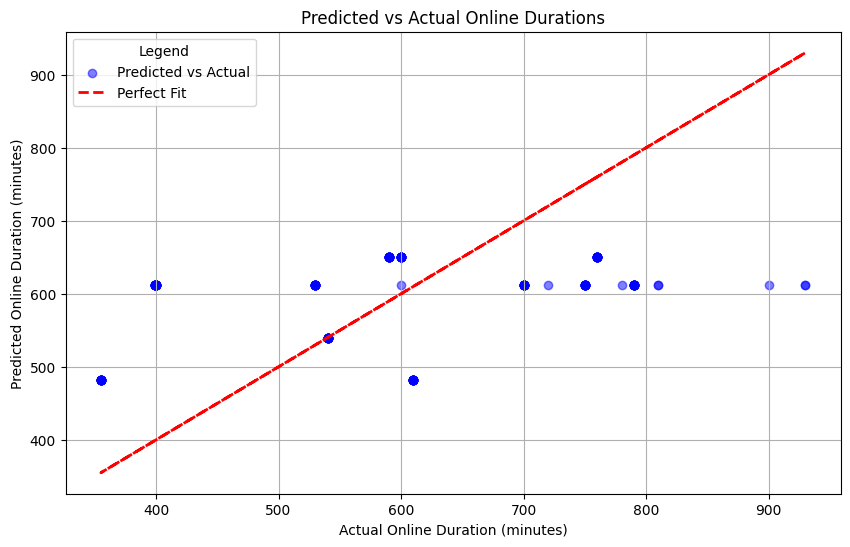

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

# Load the data from the Excel file
df = pd.read_excel('/workspaces/fdap-2024-mortezamotegh/apartment_analysis/airport_proximation_analysis/wg_listings_berlin_dummy_distance.xlsx')

# Select the dependent variable (Online Duration) and independent variables
X = df[['Distance Category_Very Close', 'Distance Category_Moderately Close', 'Distance Category_Very Far']]
y = df['Price']

# Adding a constant to the model (intercept)
X = sm.add_constant(X)

# Fit an OLS regression model
model = sm.OLS(y, X).fit()

# Predict the durations using the fitted model
predictions = model.predict(X)

# Create a scatter plot using Matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(y, predictions, color='blue', alpha=0.5, label='Predicted vs Actual')  # Actual vs Predicted scatter plot
plt.plot(y, y, color='red', linestyle='--', linewidth=2, label='Perfect Fit')  # Line for perfect fit

# Adding labels and title
plt.title('Predicted vs Actual Online Durations')
plt.xlabel('Actual Online Duration (minutes)')
plt.ylabel('Predicted Online Duration (minutes)')
plt.legend(title='Legend')
plt.grid(True)

# Show the plot
plt.show()